<a href="https://colab.research.google.com/github/yschimpf/feedback_alignment/blob/main/code/neural_network_v1" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [95]:
class NeuralNetwork(object):
  """
  Neural Network class that allows to create, train and evaluate a Neural Network
  for different regression and classification.

  Attributes
  ----------
  layers : list
  activations : list
  loss : {'MSE','LCE'}
  mode : {'BP', 'FA'}
  weights : numpy.ndarray
    Forward weights for both modes and also backward weights for BP
  feedbackweights : numpy.ndarray
    Backward weights for mode FA
  biases : numpy.ndarray
  errors : list
    Used for error plotting
  """


  def __init__(self, layers = [2,10,1], activations = ['sigmoid','identity'], loss = 'MSE', mode = 'BP'):
    """
    Constructor to create a new network with selected paramters

    Parameters
    ----------
    self : NeuralNetwork
    layers : list
      defines the number of units per unit
    activations : list
      defines the activation functions for units starting with first hidden layer.
      For regression the last layer should have the identity, for classification
      it should be softmax. Can be one of {'sigmoid', 'identity', 'relu', 'softmax'}
    loss : {'MSE', 'LCE'}
      Select either Mean Squared Error or Cross Entropy Loss
    mode = {'BP', 'FA'}
      Select eitehr Backpropagation or Feedback alignment
    """
    assert(len(layers) == len(activations)+1)
    self.layers = layers
    self.activations = activations
    self.feedbackweights = []
    self.loss = loss
    self.weights = []
    self.biases = []
    self.errors = []
    self.mode = mode

    #Random weight & bias initialization
    for i in range (len(layers)-1):
      self.weights.append(np.random.randn(layers[i+1], layers[i]))
      self.feedbackweights.append(np.random.randn(layers[i+1], layers[i]))
      self.biases.append(np.random.randn(layers[i+1], 1))


  def feedforward(self, x):
    """
    Forward pass of the neural network.

    Parameters
    ----------
    self : NeuralNetwork
    x : numpy.ndarray
    """
    #initialize for first layer
    v = np.copy(x)
    z_s = []
    v_s = [v]
    for i in range(len(self.weights)):
      #for all other layers apply weights and then the activation
      activation = self.getActivationFunction(self.activations[i])
      z_s.append(self.weights[i].dot(v)+self.biases[i])
      v = activation(z_s[-1])
      v_s.append(v)
    return (z_s, v_s)


  def backpropagation(self, y, z_s, v_s):
    """
    Backward pass for the NeuralNetwork. Applies either the Backproagation or the
    Feedback Alignment algorithm depending on class initialization

    Parameters
    ----------
    self : NeuralNetwork
    y : numpy.ndarray
    z_s : numpy.ndarray
      Inputs of units per layer.
    v_s : numpy.ndarray
      Outputs of units per layer i.e. the activated weigthed inputs.
    """

    #derivatives of Loss w.r.t the weights per layer
    dw = []
    #derivatives of loss w.r.t. to unit inputs per layer
    deltas = [None]*len(self.weights)

    #delta for las layer
    deltas[-1] = (self.getDerivativeLoss(self.loss)(v_s[-1], y))

    #backpropagation
    if(self.mode=='BP'):
      for i in reversed(range(len(deltas)-1)):
        deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.getDerivativeActivation(self.activations[i])(z_s[i]))
      batch_size = y.shape[1]
      #weight updates
      dw = [d.dot(v_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
      #bias updates
      db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for i,d in enumerate(deltas)]

    #feedback alignment
    elif(self.mode == 'FA'):
      for i in reversed(range(len(deltas)-1)):
        deltas[i] = self.feedbackweights[i+1].T.dot(deltas[i+1])*(self.getDerivativeActivation(self.activations[i])(z_s[i]))
      batch_size = y.shape[1]
      #cweight updates
      dw = [d.dot(v_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
      #bias updates
      db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for i,d in enumerate(deltas)]
    return dw, db


  def train(self, x, y, batch_size=10, epochs=100, lr = 0.01):
    """
    Trains the network i.e. compute forward pass and find updates in backward pass.

    Paramerters
    -----------
    self : NeuralNetwork
    x : numpy.ndarray
    y : numpy.ndarray
    batch_size : int
    epochs : int
    lr : float
    """
    for e in range (epochs):
      i = 0
      while(i < len(y)):
        x_batch = x[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        i = i+batch_size
        #compute forward pass
        z_s, v_s = self.feedforward(x_batch)
        #compute backward pass
        dw, db = self.backpropagation(y_batch, z_s, v_s)
        #update weights
        self.weights = [w - lr*dweight for w,dweight in zip(self.weights, dw)]
        #update biases
        self.biases = [b - lr*dbias for b,dbias in zip(self.biases, db)]
      if(e%200 == 0): print(self.getLoss(self.loss)(v_s[-1],y_batch))
      self.errors.append(self.getLoss(self.loss)(v_s[-1],y_batch))


  def predict(self, X):
    """
    Computes the predictions of the network for a particular input in
    case of classification.

    Parameter
    ---------
    self : NeuralNetwork
    X : numpy.ndarray
    """
    #compute forward pass
    _, f = self.feedforward(X)
    #predict argmax
    pred = np.argmax(f[-1], axis=0)
    return pred


  @staticmethod
  def getActivationFunction(name):
    """
    Definition of nonlinearities

    Parameter
    ---------
    name : {'sigmoid', 'identity', 'relu', 'softmax'}
    """
    if(name == 'sigmoid'):
      return lambda x : np.exp(x)/(1+np.exp(x))
    elif(name == 'identity'):
      return lambda x : x
    elif(name == 'relu'):
      def relu(x):
        y = np.copy(x)
        if(y<0):
          return 0
        else:
          return y
      return relu
    elif(name == 'softmax'):
      def softmax(x):
        #numerically stable computation of softmax
        e_x = np.exp(x-np.max(x))
        return e_x/e_x.sum(axis=0, keepdims = True)
      return softmax
    else:
      print('Unknown activation function. Identity is used')
      return lambda x:x


  @staticmethod
  def getDerivativeActivation(name):
    """
    Derivatives of activation functions

    Parameter
    ---------
    name : {'sigmoid', 'identity', 'relu', 'softmax'}
    """
    if(name == 'sigmoid'):
      sigmoid = lambda x : np.exp(x)/(1+np.exp(x))
      return lambda x : sigmoid(x)*(1-sigmoid(x))
    elif(name == 'identity'):
      return lambda x : 1
    elif(name == 'relu'):
      def drelu(x):
        y = np.copy(x)
        if(y >= 0): y = 1
        else: y = 0
        return y
      return drelu
    elif(name == 'softmax'):
      print('In this code access to softmax derivatives should not be required via this function please redefine your network. Please redefine your network. Identity was used instead.')
      return exit()
    else:
      print('Unknown activation, identity was used instead')
      return lambda x : 1


  @staticmethod
  def getLoss(name):
    """
    Definitions of loss functions

    Parameter
    ---------
    name : {'MSE', 'LCE'}
    """
    if(name == 'MSE'):
      return lambda f, y : np.linalg.norm(f-y)
    elif(name == 'LCE'):
      return lambda f, y : -(y*np.log(f)).sum()
    else:
      print('Unknown loss, cannot make useful computations')
      exit()


  @staticmethod
  def getDerivativeLoss(name):
    """
    Computes the ferivative of the last layer w.r.t. to the loss

    Parameter
    ---------
    name = {'MSE','LCE'}
    """
    if(name == 'MSE'):
      return lambda f, y : (f-y)
    elif(name == 'LCE'):
      return lambda f, y : (f-y)
    else:
      print('Unknown loss, cannot make useful computations')
      exit()


353.42297182798563
6.599478603728549
5.869614920519029
5.162627207972838
4.591420179068877
4.1955824078920605
3.898330522671531
3.656149080377773
3.4502483622926645
3.270703198645953
3.111092091394336
2.9669026177967748
2.8349151239794748
2.7128383182936666
2.5990388573734653
2.492335645082576
2.3918505331397126
2.2969065028754567
2.206962306252658
2.1215725050769794
2.0403635634790787
1.9630191316729118
1.8892700886030644
1.8188868402917906
1.7516726802428464


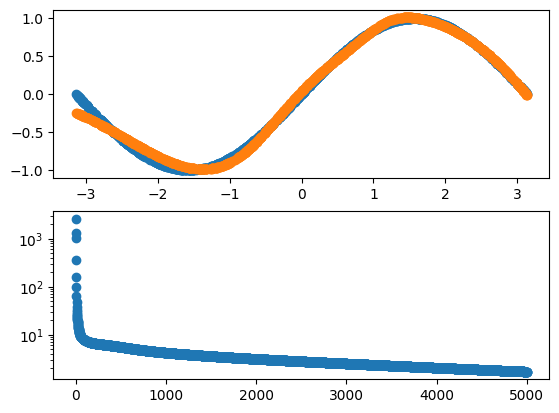

In [50]:
#first testrun
import matplotlib.pyplot as plt
nn = NeuralNetwork([1,20,100,1], activations = ['sigmoid','sigmoid','identity'], loss = 'MSE', mode = 'BP')
X = 2 * np.pi * np.random.rand(1000).reshape(1,-1) - np.pi
y = np.sin(X)
#print(X.shape)
#print(y.shape)
#print(X)
n_epoch = 5000
nn.train(X,y,epochs=n_epoch,batch_size = 64, lr = .1)
_,v_s_bp= nn.feedforward(X)

#nn_ = NeuralNetwork([1,20,100,1], activations = ['sigmoid','sigmoid','identity'], loss = 'MSE', mode = 'FA')
#nn_.train(X,y,epochs=n_epoch,batch_size = 64, lr = 0.001)
#_,v_s_fa= nn_.feedforward(X)
#print(y,X)
fig, ax = plt.subplots(2)
ax[1].set_yscale('log')
ax[0].scatter(X.flatten(), y.flatten())
ax[0].scatter(X.flatten(),v_s_bp[-1].flatten())
#ax[0].scatter(X.flatten(),v_s_fa[-1].flatten())
ax[1].scatter(np.arange(n_epoch).flatten(),nn.errors)
#ax[1].scatter(np.arange(n_epoch).flatten(),nn_.errors)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


1396.5205873932634
570.2821873873716
499.8938102867683
456.89432763595744
428.2176368946135
405.7691293566388
386.6950151926677
369.9136056192791
354.8970919623497
341.3223090893682
328.9525646874831
317.5941256034099
307.07930924872267
297.2602254535993
288.0074910476304
279.21415326498015
270.8088407289433
262.7777605912496
255.1764428566429
248.09775770838957
241.5995431384784
235.6570968497524
230.18198938237936
225.07069427721208
220.23750333628928


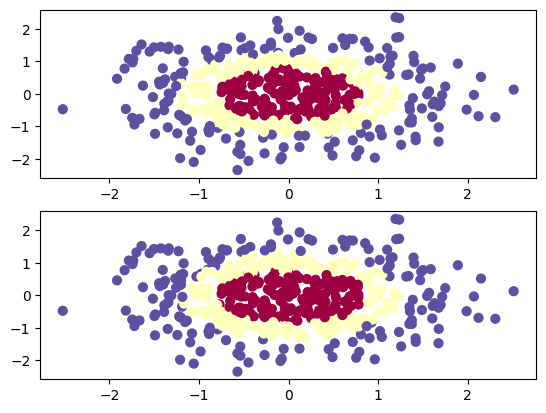

In [96]:
import sklearn.datasets
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

def load_extra_datasets():
    N = 500
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.7, n_samples=N, n_features=2, n_classes=3, shuffle=True, random_state=None)
    return  gaussian_quantiles
gaussian_quantiles= load_extra_datasets()
X, Y = gaussian_quantiles
y = []
X, Y = X.T, Y.reshape(1, Y.shape[0])
Y = Y.reshape(-1, 1)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform Y to one-hot encoding
Y_onehot = encoder.fit_transform(Y)
# Visualize the data
fig, ax = plt.subplots(2)
ax[0].scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
nn = NeuralNetwork([2,50,50,3], activations = ['sigmoid','sigmoid','softmax'], loss = 'LCE',mode='BP')
n_epoch = 5000
#print(Y)
#print(Y_onehot.T)
nn.train(X,Y_onehot.T,epochs=n_epoch,batch_size = 64, lr = 0.01)
pred = nn.predict(X)
#print(pred)
#print(pred.reshape(1, Y.shape[0]).reshape(-1, 1))
ax[1].scatter(X[0, :], X[1, :], c=pred.reshape(1, Y.shape[0]).reshape(-1, 1), s=40, cmap=plt.cm.Spectral)
#print(y,X)

In [89]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
#testing stuff
nn = NeuralNetwork([1,3,2], activations = ['sigmoid', 'softmax'], loss = 'LCE',mode='BP')
z_s, v_s = nn.feedforward(np.array([[1]]))
dw, db = nn.backpropagation(np.array([[[1][0]]]), z_s, v_s)
print("nn.weights:")
print(nn.weights)
print("nn.biases:")
print(nn.biases)
print("dw:")
print(dw)
print("db:")
print(db)
print("updated weights")
print([w - 0.1*dweight for w,dweight in zip(nn.weights, dw)])
print("v_s -1")
print(v_s[-1])
print("v_s 1")
print(v_s[1])
print("v_s 0")
print(v_s[0])
print("z_s -1")
print(z_s[-1])
print("z_s 0")
print(z_s[0])


Using cpu device
nn.weights:
[array([[-0.21600468],
       [ 0.93597006],
       [ 0.65579481]]), array([[-0.66020906,  2.49195738,  0.59909082],
       [ 1.16081809, -0.1315292 ,  0.81265723]])]
nn.biases:
[array([[-0.66025731],
       [ 1.64337481],
       [ 1.13384831]]), array([[-0.77422315],
       [ 1.0832588 ]])]
dw:
[array([[-0.03900657],
       [-0.08320423],
       [-0.08566736]]), array([[-0.15704298, -0.4965918 , -0.45778592],
       [-0.13691001, -0.43292856, -0.3990976 ]])]
db:
[array([[-0.03900657],
       [-0.08320423],
       [-0.08566736]]), array([[-0.53424521],
       [-0.46575479]])]
updated weights
[array([[-0.21210402],
       [ 0.94429048],
       [ 0.66436155]]), array([[-0.64450476,  2.54161656,  0.64486942],
       [ 1.17450909, -0.08823634,  0.85256699]])]
v_s -1
[[0.46575479]
 [0.53424521]]
v_s 1
[[0.29395299]
 [0.92952036]
 [0.85688352]]
v_s 0
[[1]]
z_s -1
[[1.8613826 ]
 [1.99857825]]
z_s 0
[[-0.87626199]
 [ 2.57934487]
 [ 1.78964312]]


In [ ]:
def softmax(x):
    """ applies softmax to an input x"""
    e_x = np.exp(x)
    return e_x / e_x.sum(axis=1, keepdims = True)

x = np.array([[1, 0, 3, 5],[1, 0, 3, 5]])
print(x.shape)
y = softmax(x)
y, x / x.sum()